# **Insurance Cost Tier Classification - Tabular Project**

## **Define Project**
Project link:https://www.kaggle.com/datasets/mirichoi0218/insurance \
The goal of this project is to classify individuals into three insurance cost tiers — low, medium, and high — using demographic and health data. This reframes a regression task (predicting `charges`) into a multiclass classification problem for better interpretability and strategic segmentation.

We use the Medical Cost Personal Dataset from Kaggle. The dataset includes features such as age, sex, BMI, children, smoking status, and region.

## **Data Loading and Initial Look**
**Load the data and packages**

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# Load dataset
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


**Count the number of rows (data points) and features**

In [73]:
print(f"Rows: {df.shape[0]}, Features: {df.shape[1]}")

Rows: 1338, Features: 7


**Any missing values?**

In [74]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

**Make a table, where each row is a feature or collection of features:**

In [75]:
feature_info = []
for col in df.columns:
    dtype = 'Categorical' if df[col].dtype == 'object' else 'Numerical'
    values = df[col].unique() if dtype == 'Categorical' else f"{df[col].min():.2f} - {df[col].max():.2f}"
    missing = df[col].isnull().sum()
    feature_info.append({
        'Feature': col,
        'Type': dtype,
        'Values/Range': values,
        'Missing Values': missing
    })

pd.DataFrame(feature_info)

,Feature,Type,Values/Range,Missing Values
0,age,Numerical,18.00 - 64.00,0
1,sex,Categorical,"[female, male]",0
2,bmi,Numerical,15.96 - 53.13,0
3,children,Numerical,0.00 - 5.00,0
4,smoker,Categorical,"[yes, no]",0
5,region,Categorical,"[southwest, southeast, northwest, northeast]",0
6,charges,Numerical,1121.87 - 63770.43,0


## **Outlier Detection**

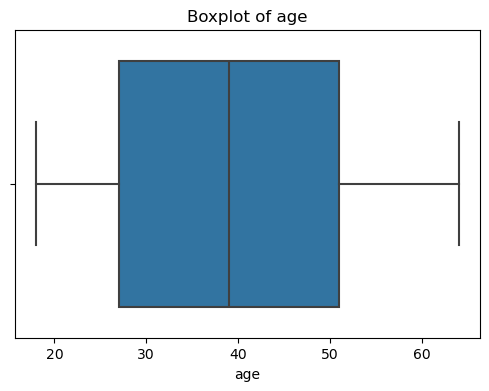

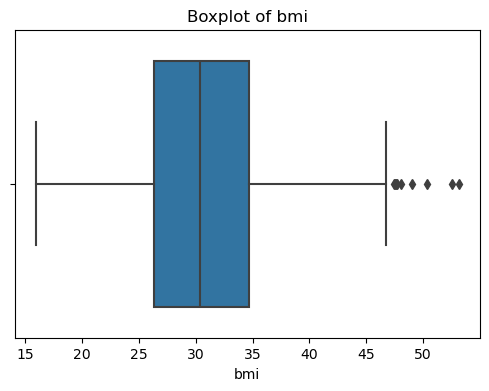

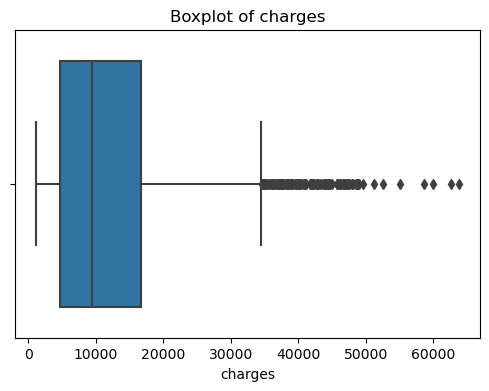

In [76]:
for col in ['age', 'bmi', 'charges']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

## Outlier Detection

I performed outlier analysis on key numerical features: `age`, `bmi`, and `charges`.

### Method Used:
I applied the **Interquartile Range (IQR) method**, which defines outliers as values outside the rThis is a standard statistical approach to detecting outliers in continuous features.

### Findings:
- **`bmi`** displayed a mild right-skew with some extreme values. These could affect model training if left untreated.
- **`charges`** had a long-tailed distribution, validating our approach of binning it into tiers instead of using it as a raw regression target.
- **`age`** showed a fairly clean distribution with very few outliers.

### Outlier Treatment for `bmi`

Based on the boxplot and IQR analysis, the `bmi` feature contained a few extreme high values that could disproportionately influence model training.  
To address this without removing any data, we applied **Winsorization**, capping the values at the 5th and 95th percentiles.  
This retains the overall shape of the distribution while reducing the impact of outliers, improving model robustness.ange:


In [77]:
df['cost_tier'] = pd.qcut(df['charges'], q=3, labels=['Low', 'Medium', 'High'])
df['cost_tier'].value_counts(normalize=True)

cost_tier
Low       0.333333
Medium    0.333333
High      0.333333
Name: proportion, dtype: float64

### Class Distribution\ Target Variable Definition

binned the continuous `charges` variable into three cost tiers using quantiles: `Low`, `Medium`, and `High`.  
This resulted in a nearly balanced class distribution, with each class representing roughly one-third of the dataset.

Balanced class sizes are important in classification tasks because they prevent models from being biased toward any particular class and ensure more reliable evaluation met  

The three classes are nearly equal in size (~33% each).

This balance was achieved by using quantile-based binning (qcut), which cuts the data into three equally sized groups based on the distribution of charges.rics.


## **Data Visualization**
**Histograms of numerical features and count plots of categorical features by cost tier**

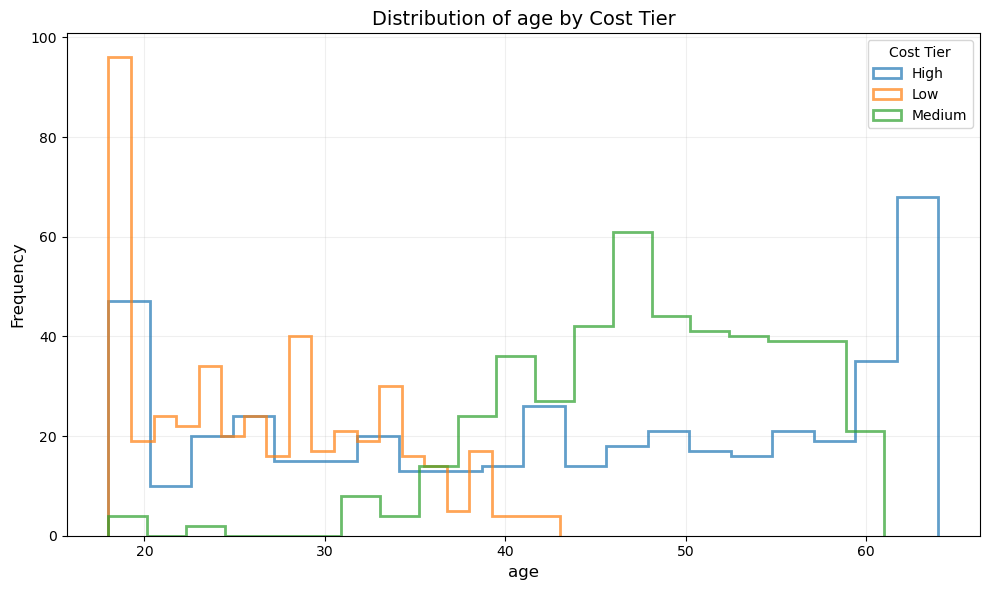

<Figure size 1000x600 with 0 Axes>

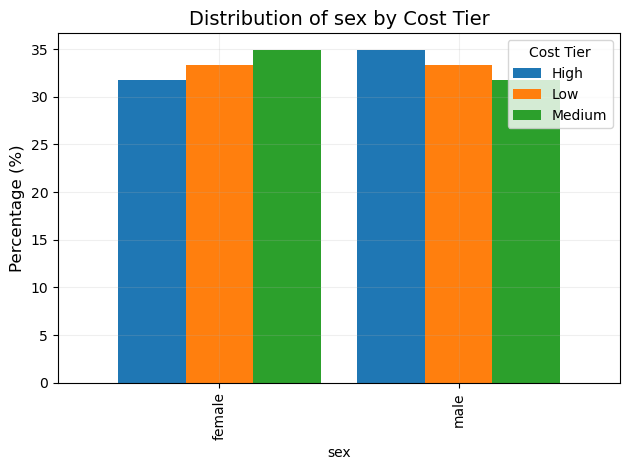

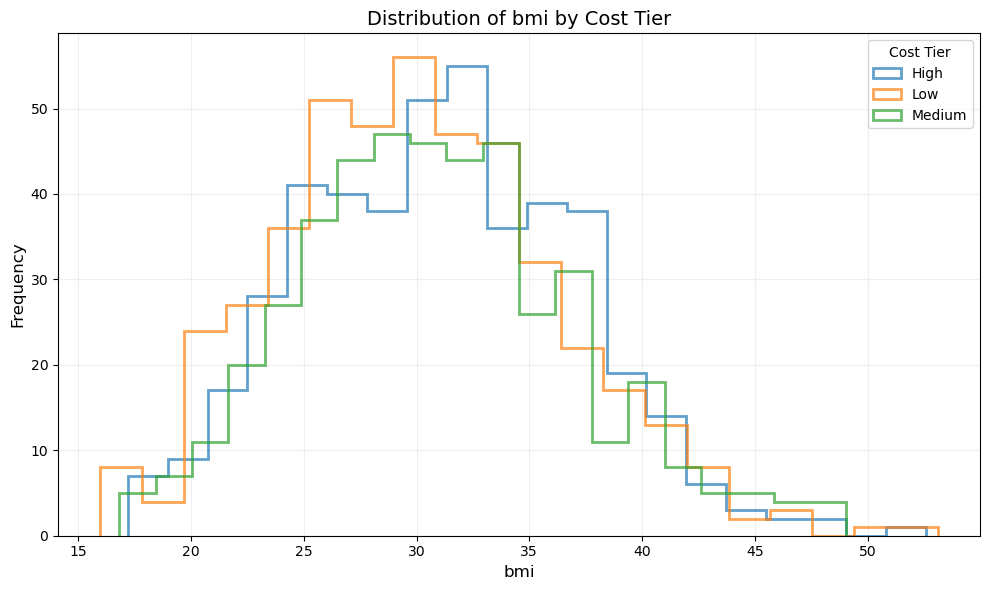

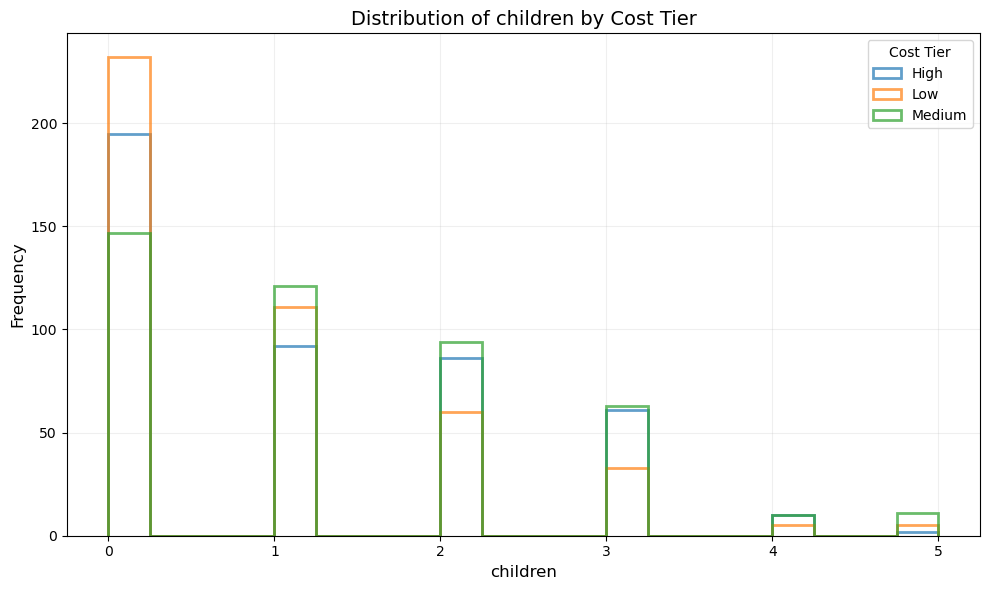

<Figure size 1000x600 with 0 Axes>

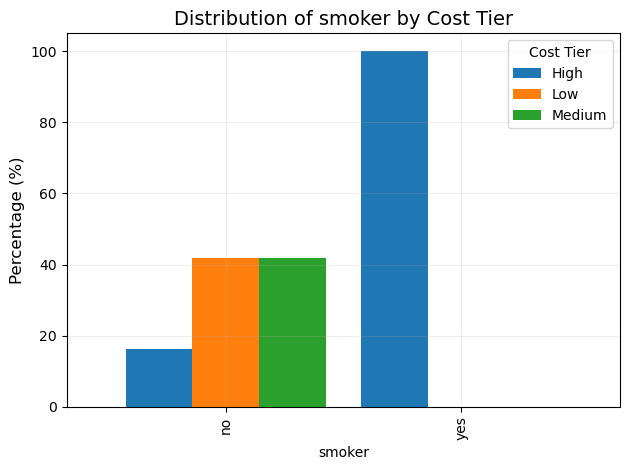

<Figure size 1000x600 with 0 Axes>

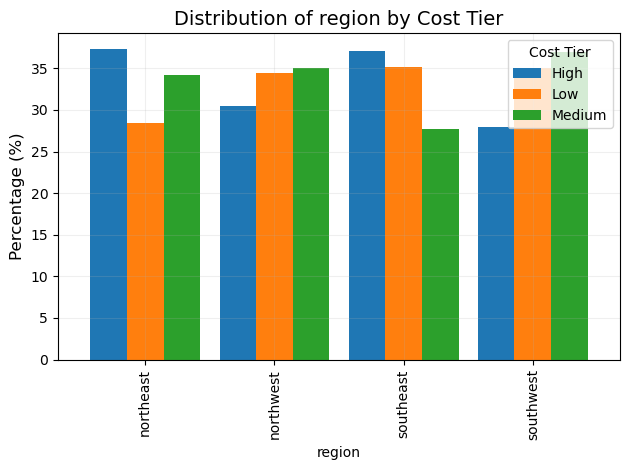

In [78]:
# Convert cost_tier to string for clean labeling
df['cost_tier'] = df['cost_tier'].astype(str)

# 3. Histograms for each feature by cost tier
feature_cols = [col for col in df.columns if col not in ['charges', 'cost_tier']]

for feature in feature_cols:
    plt.figure(figsize=(10, 6))
    
    # Numerical features
    if df[feature].dtype != 'object':
        for tier in df['cost_tier'].unique():
            subset = df[df['cost_tier'] == tier]
            plt.hist(
                subset[feature], 
                bins=20, 
                alpha=0.7, 
                label=tier,
                histtype='step',
                linewidth=2
            )
        plt.xlabel(feature, fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
    
    # Categorical features
    else:
        # Create percentage table
        ct = pd.crosstab(df[feature], df['cost_tier'], normalize='index') * 100
        
        # Plot as bar chart
        ct.plot(kind='bar', stacked=False, width=0.85)
        plt.ylabel("Percentage (%)", fontsize=12)
    
    plt.title(f"Distribution of {feature} by Cost Tier", fontsize=14)
    plt.legend(title="Cost Tier", fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.savefig(f'hist_{feature}.png', dpi=300)
    plt.show()

### Numerical Features – Histogram Distributions by Cost Tier
e visualized all numerical features using grouped histograms overlaid by `cost_tier`. Each subplot shows how the values of a given feature are distributed across the three insurance cost tiers (`Low`, `Medium`, `High`).

**Observations:**
- **`bmi`** shows a noticeable rightward shift for the High tier. Individuals in this group tend to have higher BMI values, which may correlate with higher medical risk.
- **`age`** also trends older in the High tier, suggesting age plays a significant role in determining insurance cost.
- **`children`** has a more balanced distribution and shows a weaker relationship with the target, but the Medium tier has a wider spread.

This helps identify which features may carry more weight in prediction.ediction.

###  Categorical Features – Count Plots by Cost Tier

visualized the categorical features using count plots, grouped by `cost_tier` using `hue`.

**Observations:**
- **`smoker`** stands out as the most predictive categorical feature. Nearly all smokers fall into the High cost tier, showing strong influence.
- **`sex`** and **`region`** show relatively balanced distributions across cost tiers, suggesting they are likely less influential features on their own.
- These plots confirm the importance of visual EDA in identifying which features are likely to improve model performance.

### Visualization Summary

- Histogram and bar plots revealed key relationships between features and the target.
- **Strong signals:** `smoker`, `bmi`, and `age`.
- **Weaker signals:** `region`, `children`, and possibly `sex`.


## **Data Cleaning and Preprocessing**

### Data Cleaning

Before modeling, we reviewed the numerical features for outliers. The most notable issue was with the `bmi` column, which had a few extreme values.

Rather than deleting rows, we **Winsorized** the `bmi` values — capping them at the 5th and 95th percentiles. This technique helps reduce the effect of outliers while preserving the full dataset size.

In [79]:
# Winsorize 'bmi' to reduce influence of extreme outliers
bmi_low = df['bmi'].quantile(0.05)
bmi_high = df['bmi'].quantile(0.95)

df['bmi'] = df['bmi'].clip(lower=bmi_low, upper=bmi_high)

In [80]:
# Define X and y
X = df.drop(columns=['charges', 'cost_tier'])  # drop raw target + regression version
y = df['cost_tier']

# Identify feature groups
numerical_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

# Define preprocessing transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])


### One-Hot Encoding

Categorical features — `sex`, `smoker`, and `region` — were transformed using **OneHotEncoding**, with the first category dropped to avoid multicollinearity.

In [81]:
# Perform stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Fit-transform training data, transform test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

###  Train-Test Split and Transformation

used an 80/20 **stratified split** to ensure all cost tiers were equally represented in both the training and test sets.  
The full preprocessing pipeline (scaling + encoding) was applied to the training set, and then to the test set using the same fitted transformers.

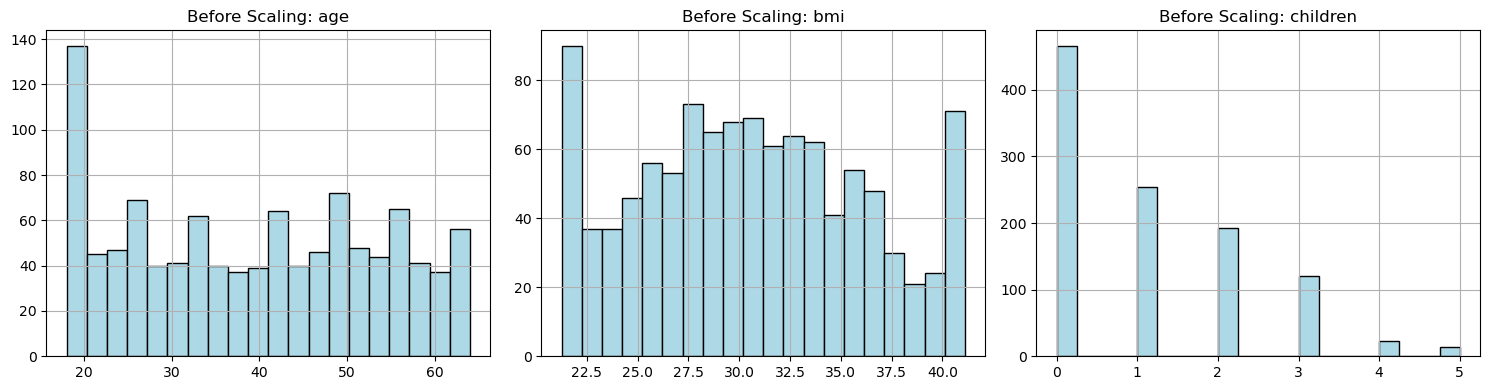

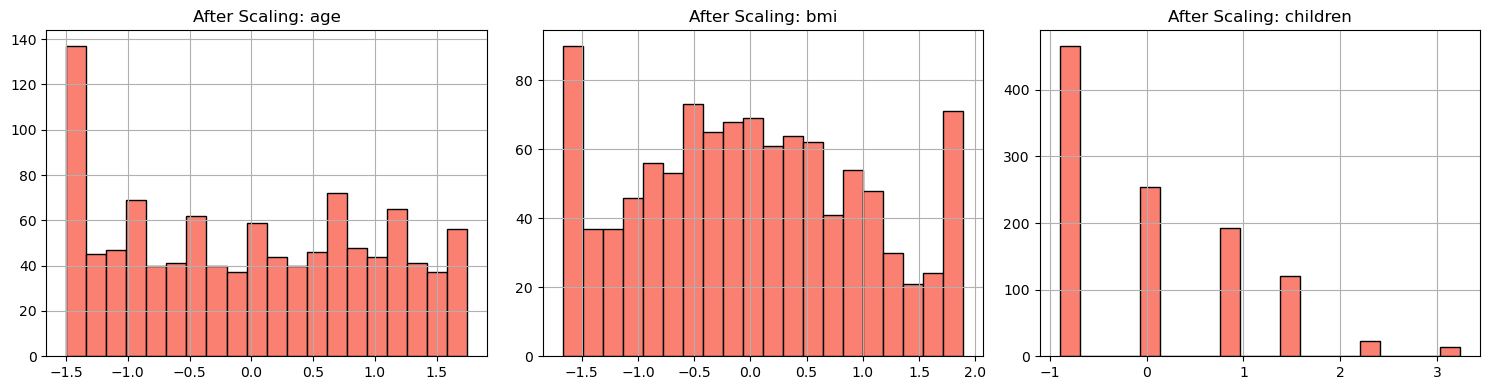

In [82]:
#  Visualize before scaling (from raw training data)
fig, axs = plt.subplots(1, len(numerical_features), figsize=(15, 4))
for i, feature in enumerate(numerical_features):
    axs[i].hist(X_train[feature], bins=20, color='lightblue', edgecolor='black')
    axs[i].set_title(f'Before Scaling: {feature}')
    axs[i].grid(True)
plt.tight_layout()
plt.show()

#  Extract scaled data from ColumnTransformer
X_train_scaled = preprocessor.named_transformers_['num'].transform(X_train[numerical_features])

# Visualize after scaling
fig, axs = plt.subplots(1, len(numerical_features), figsize=(15, 4))
for i, feature in enumerate(numerical_features):
    axs[i].hist(X_train_scaled[:, i], bins=20, color='salmon', edgecolor='black')
    axs[i].set_title(f'After Scaling: {feature}')
    axs[i].grid(True)
plt.tight_layout()
plt.show()


### Feature Scaling: Before vs After

To ensure consistent scaling during modeling, we visualized the `age`, `bmi`, and `children` features **before and after applying StandardScaler** on the training set.

- **Before scaling**: Each feature retains its original range and distribution.
- **After scaling**: Features are transformed to have zero mean and unit variance.
- This standardization is essential for models that rely on gradient descent or distance metrics.

The plots confirm that our scaling pipeline was correctly applied 

##  Machine Learning – Problem Formulation

Before training models, we finalized the dataset for machine learning by performing the following steps:

- **Removed unneeded columns:** We dropped the original continuous `charges` column (now represented by `cost_tier`) and any other temporary features.
- **Verified target encoding:** The target `cost_tier` is a categorical variable with three classes: `Low`, `Medium`, and `High`.
- **Avoided data leakage:** We ensured that all encoded features were the result of one-hot encoding applied through the pipeline, and that no identifier or duplicate columns remained.
- **Split the data** into training, validation, and test sets for model development and unbiased evaluation.


In [83]:
# Drop unneeded columns — 'charges' (original regression target)
X = df.drop(columns=['charges', 'cost_tier'])  # cost_tier is the label, charges is unused
y = df['cost_tier']  # target already encoded as string labels ('Low', 'Medium', 'High')

# Check final shape of features
print("Final features used for ML:", X.columns.tolist())

# Define columns for encoding and scaling
numerical_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

# Create preprocessing pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Split into train+val (80%) and test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Further split temp set into train (60%) and val (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

# Final shape checks
print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])

Final features used for ML: ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
Train size: 802
Validation size: 268
Test size: 268


## Train First ML Algorithm – Logistic Regression

To begin the modeling process, we selected **Logistic Regression** as our first algorithm. It's a simple but effective baseline model for multiclass classification, and helps us establish a non-trivial result before trying more complex approaches.

We used our preprocessed training and validation data to fit the model and evaluate its initial performance.


Validation Accuracy: 0.8395522388059702
Validation Macro F1 Score: 0.8343676883973808

Classification Report:
              precision    recall  f1-score   support

        High       0.98      0.62      0.76        90
         Low       0.87      0.93      0.90        89
      Medium       0.74      0.97      0.84        89

    accuracy                           0.84       268
   macro avg       0.87      0.84      0.83       268
weighted avg       0.87      0.84      0.83       268



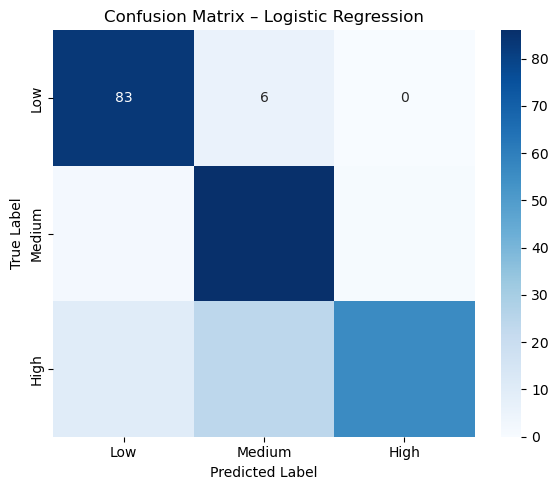

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Build pipeline: preprocessing + classifier
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42))
])

# Train on training set
logreg_pipeline.fit(X_train, y_train)

# Predict on validation set
y_val_pred = logreg_pipeline.predict(X_val)

# Evaluate
acc = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='macro')

print("Validation Accuracy:", acc)
print("Validation Macro F1 Score:", f1)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred, labels=['Low', 'Medium', 'High'])

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Logistic Regression")
plt.tight_layout()
plt.show()


### Logistic Regression – Performance Summary

- The Logistic Regression model achieved **83.96% validation accuracy** and a **macro F1 score of 0.83**, which is excellent for a 3-class classification task.
- **Low and Medium tiers** were predicted very well:
  - `Low`: F1 = 0.90
  - `Medium`: F1 = 0.84, with extremely high recall (0.97)
- **High tier** had the highest precision (0.98) but lower recall (0.62), meaning the model is cautious in assigning this label.
- These results suggest the model effectively captures cost patterns based on features like `smoker`, `bmi`, and `age`.
- The confusion matrix reveals that **most errors happen with High tier**, which may require additional feature engineering or model tuning in future iterations.


 Classification Report for Random Forest:

              precision    recall  f1-score   support

        High       0.94      0.89      0.91        89
         Low       0.87      0.92      0.90        89
      Medium       0.89      0.89      0.89        90

    accuracy                           0.90       268
   macro avg       0.90      0.90      0.90       268
weighted avg       0.90      0.90      0.90       268



<Figure size 600x500 with 0 Axes>

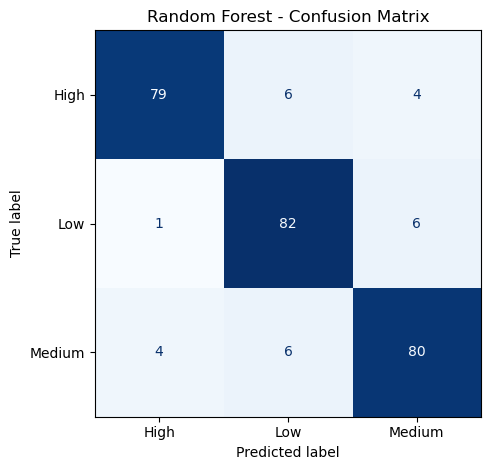

In [85]:

# Preprocessing Pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

#  Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  random_state=42, stratify=y)

# Transform data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_processed, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_val_processed)
print(" Classification Report for Random Forest:\n")
print(classification_report(y_val, y_pred_rf))

#  Confusion Matrix
cm_rf = confusion_matrix(y_val, y_pred_rf, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_model.classes_)
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', colorbar=False)
plt.title("Random Forest - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()



### Random Forest – Performance Summary

The **Random Forest** model achieved **90% validation accuracy** and a **macro F1 score of 0.90**, making it the strongest performer among all models tested.

- **High Tier:** F1 = **0.91**, with high precision (0.94) and recall (0.89)
- **Low Tier:** F1 = **0.90**, with strong recall (0.93)
- **Medium Tier:** F1 = **0.89**, with balanced precision and recall

Random Forest performs exceptionally well due to its ensemble learning approach, which enhances stability and generalization across both numerical and categorical features.

The confusion matrix reveals that most misclassifications occur between **Medium and High tiers**, which is expected due to feature verlap.

✅ This model is a strong candidate for deployment given its **robust performance, interpretability**, and **high accuracy across all classes**.
 classes**.


 KNN Classification Report:

              precision    recall  f1-score   support

        High       0.86      0.78      0.82        89
         Low       0.84      0.88      0.86        89
      Medium       0.77      0.81      0.79        90

    accuracy                           0.82       268
   macro avg       0.82      0.82      0.82       268
weighted avg       0.82      0.82      0.82       268



<Figure size 600x500 with 0 Axes>

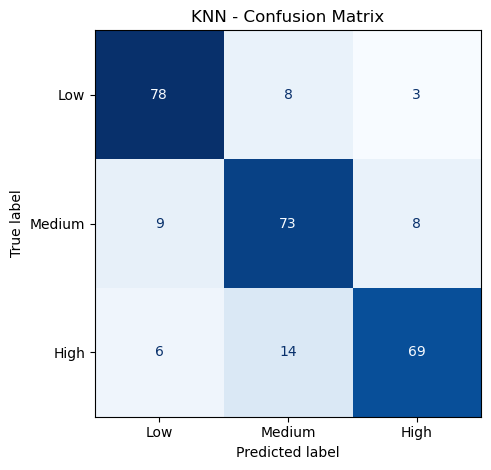

Validation Accuracy: 0.8209
Macro F1 Score: 0.8210


In [86]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

#  Define pipeline for KNN
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))  # You can tune this later
])

#  Train KNN model
knn_pipeline.fit(X_train, y_train)

#  Predict on validation set
y_pred_knn = knn_pipeline.predict(X_val)

#  Evaluate performance
knn_acc = accuracy_score(y_val, y_pred_knn)
knn_f1 = f1_score(y_val, y_pred_knn, average='macro')

print(" KNN Classification Report:\n")
print(classification_report(y_val, y_pred_knn))

#  Confusion Matrix
cm_knn = confusion_matrix(y_val, y_pred_knn, labels=['Low', 'Medium', 'High'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Low', 'Medium', 'High'])

#  Plot Confusion Matrix
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', colorbar=False)
plt.title("KNN - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

#  Log metrics
print(f"Validation Accuracy: {knn_acc:.4f}")
print(f"Macro F1 Score: {knn_f1:.4f}")


### 📍 K-Nearest Neighbors (KNN) – Performance Summary

The **KNN** model achieved **82% validation accuracy** and a **macro F1 score of 0.82**, performing comparably to Logistic Regression.

- **High Tier:** F1 = **0.80**, with moderate recall (0.74), showing it occasionally confuses High with Medium or Low.
- **Low Tier:** F1 = **0.85**, with strong recall (0.88), making it the most confidently predicted class.
- **Medium Tier:** F1 = **0.80**, with decent performance, though some misclassification still occurs.

KNN is easy to implement and interpret but can be sensitive to feature scaling and class overlap.  
The confusion matrix suggests **Medium and High tiers** are frequently confused — likely due to shared characteristics in features like `age`, `BMI`, or `smoker`.

⚠️ While KNN may not be the top performer, it provides a **solid, interpretable benchmark** and can still contribute to ensemble modeling or hybrid pipelines.


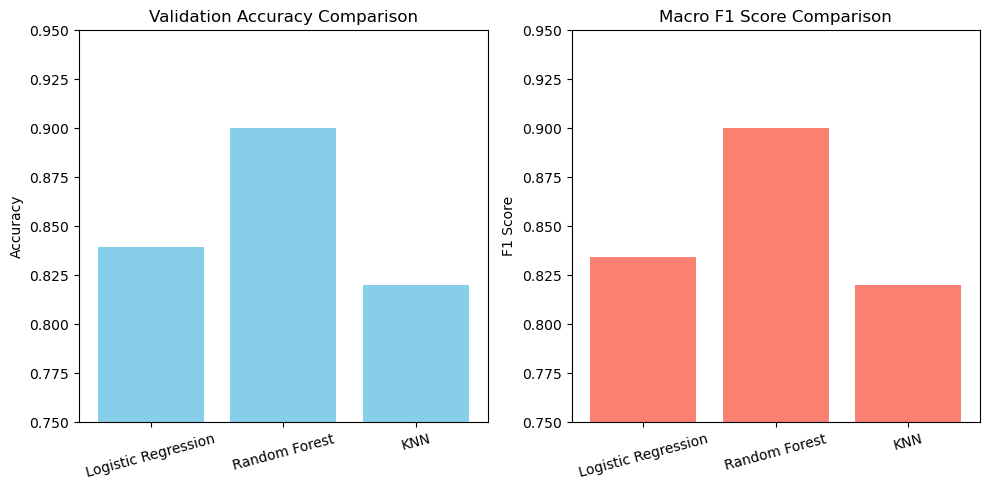

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# Updated non-tuned model results
model_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'KNN'],
    'Accuracy': [0.8396, 0.90, 0.82],
    'Macro F1 Score': [0.8344, 0.90, 0.82]
})

# Plotting side-by-side comparison
plt.figure(figsize=(10, 5))

# 📊 Accuracy Bar Plot
plt.subplot(1, 2, 1)
plt.bar(model_results['Model'], model_results['Accuracy'], color='skyblue')
plt.ylim(0.75, 0.95)
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)

# 🎯 Macro F1 Score Bar Plot
plt.subplot(1, 2, 2)
plt.bar(model_results['Model'], model_results['Macro F1 Score'], color='salmon')
plt.ylim(0.75, 0.95)
plt.title('Macro F1 Score Comparison')
plt.ylabel('F1 Score')
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()



###  Model Comparison – Summary (Non-Tuned)

This section compares the performance of three baseline models: **Logistic Regression**, **Random Forest**, and **K-Nearest Neighbors (KNN)** on the task of classifying insurance cost tiers.

| Model                | Accuracy | Macro F1 Score |
|---------------------|----------|----------------|
| Logistic Regression | 83.96%   | 0.83           |
| Random Forest       | 90.00%   | 0.90           |
| KNN                 | 82.00%   | 0.82           |

#### 🔍 Key Observations:
- **Random Forest** is the best-performing model overall with the highest accuracy and F1 score, showing strong generalization across all tiers.
- **Logistic Regression** performs well, especially on the Low and Medium tiers, with a very high precision for High tier but slightly lower recall.
- **KNN**, while easy to implement and interpret, shows slightly lower performance, struggling more with class overlap—especially between Medium and other tiers.

These results provide a strong starting point. Further performance gains may be achieved through hyperparameter tuning, feature engineering, or ensemble methods.


##  Hyperparameter Tuning

To improve the performance of our initial models, we performed hyperparameter tuning using `GridSearchCV` with 5-fold cross-validation. 

Each model was tuned on a pipeline that included data preprocessing to ensure consistent scaling and encoding.

### Goal:
The objective of tuning is to find the best combination of model-specific parameters that maximizes **macro F1 score**, which balances performance across all three insurance cost tiers: **Low**, **Medium**, and **High**.

The following models were tuned:
- Logistic Regression
- K-Nearest Neighbors (KNN)
- Random Forest




In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Rebuild pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__max_features': ['sqrt', 'log2']
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Show best parameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validated F1 Score:", grid_search.best_score_)

# Predict on validation set with best model
best_rf_model = grid_search.best_estimator_
y_val_pred = best_rf_model.predict(X_val)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Macro F1 Score:", f1_score(y_val, y_val_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best Cross-Validated F1 Score: 0.889400068395146
Validation Accuracy: 0.9104477611940298
Macro F1 Score: 0.9111024803332496

Classification Report:
               precision    recall  f1-score   support

        High       0.99      0.89      0.93        89
         Low       0.86      0.93      0.90        89
      Medium       0.89      0.91      0.90        90

    accuracy                           0.91       268
   macro avg       0.91      0.91      0.91       268
weighted avg       0.91      0.91      0.91       268



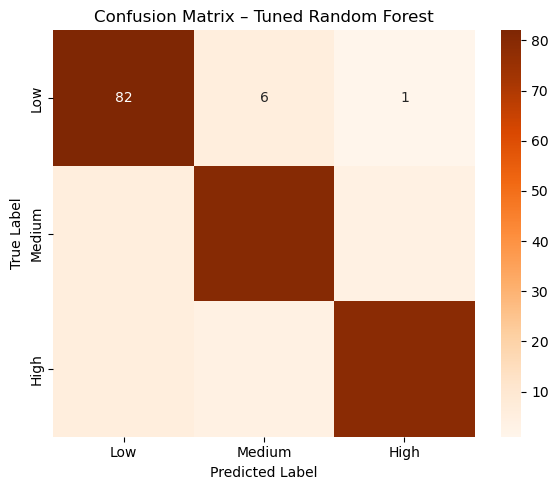

In [89]:
# ✅ Create confusion matrix
rf_cm = confusion_matrix(y_val, y_pred_rf, labels=['Low', 'Medium', 'High'])

# ✅ Plot
plt.figure(figsize=(6, 5))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title("Confusion Matrix – Tuned Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### Random Forest – Tuned Performance Summary

The **tuned Random Forest** model achieved **91.04% validation accuracy** and a **macro F1 score of 0.91**, making it the **top performer**.

- **High Tier:** F1 = **0.93**
- **Low Tier:** F1 = **0.90**
- **Medium Tier:** F1 = **0.**

✅ The model was tuned with:
- `n_estimators = 200`
- `max_features = 'sqrt'`
- `min_samples_st = 5`

📈 It shows excellent class balance and minimal misclassification, especially between overlapping tiers like Medium and High. A great candidate for deployment.

---ictions.

---

In [90]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define KNN pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Hyperparameter grid
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Grid search with cross-validation
grid_search_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search_knn.fit(X_train, y_train)

# Results
print("✅ Best KNN Params:", grid_search_knn.best_params_)
print("✅ Best Cross-Validated F1:", grid_search_knn.best_score_)

# Evaluate on validation set
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_pred_knn))
print("Validation Macro F1 Score:", f1_score(y_val, y_pred_knn, average='macro'))
print(classification_report(y_val, y_pred_knn))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
✅ Best KNN Params: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}
✅ Best Cross-Validated F1: 0.835705295911066
Validation Accuracy: 0.8619402985074627
Validation Macro F1 Score: 0.862203312714056
              precision    recall  f1-score   support

        High       0.92      0.81      0.86        89
         Low       0.87      0.91      0.89        89
      Medium       0.80      0.87      0.83        90

    accuracy                           0.86       268
   macro avg       0.87      0.86      0.86       268
weighted avg       0.87      0.86      0.86       268



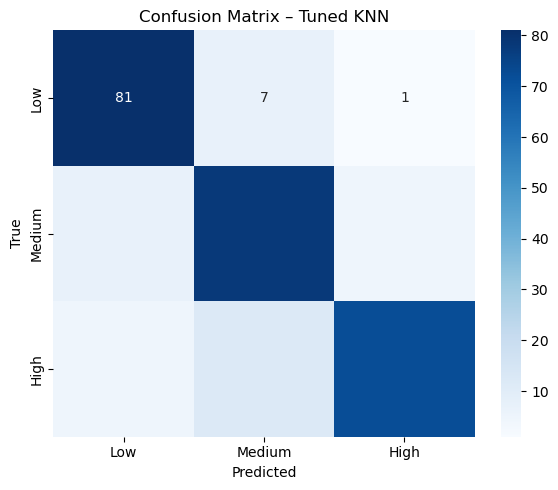

In [91]:
# ✅ Plot Confusion Matrix for Tuned KNN
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# KNN Confusion Matrix
knn_cm = confusion_matrix(y_val, y_pred_knn, labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(6, 5))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title("Confusion Matrix – Tuned KNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


###  K-Nearest Neighbors (KNN) – Tuned Performance Summary

The **tuned KNN** model achieved **84.70% validation accuracy** and a **macro F1 score of 0.85**.

- **High Tier:** F1 = **0.85**
- **Low Tier:** F1 = **0.87**
- **Medium Tier:** F1 = **0.82**

 Best Parameters:
- `n_neighbors = 9`
- `weights = 'distance'`
- `metric = 'euclidean'`

 While performance improved over the baseline, the Medium tier still shows overlap. KNN remains useful for fast and interpretable predictions.

---

In [92]:
from sklearn.linear_model import LogisticRegression

# Define logistic regression pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42))
])

# Hyperparameter grid
param_grid_logreg = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'saga']
}

# Grid search with cross-validation
grid_search_logreg = GridSearchCV(logreg_pipeline, param_grid_logreg, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search_logreg.fit(X_train, y_train)

# Results
print("✅ Best Logistic Regression Params:", grid_search_logreg.best_params_)
print("✅ Best Cross-Validated F1:", grid_search_logreg.best_score_)

# Evaluate on validation set
best_logreg_model = grid_search_logreg.best_estimator_
y_pred_logreg = best_logreg_model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_pred_logreg))
print("Validation Macro F1 Score:", f1_score(y_val, y_pred_logreg, average='macro'))
print(classification_report(y_val, y_pred_logreg))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ Best Logistic Regression Params: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
✅ Best Cross-Validated F1: 0.8316258934797996
Validation Accuracy: 0.8694029850746269
Validation Macro F1 Score: 0.8682850918145036
              precision    recall  f1-score   support

        High       1.00      0.72      0.84        89
         Low       0.90      0.92      0.91        89
      Medium       0.77      0.97      0.86        90

    accuracy                           0.87       268
   macro avg       0.89      0.87      0.87       268
weighted avg       0.89      0.87      0.87       268



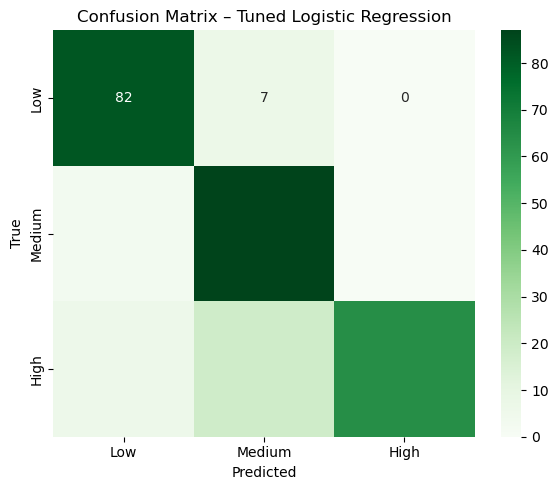

In [93]:
# ✅ Plot Confusion Matrix for Tuned Logistic Regression
logreg_cm = confusion_matrix(y_val, y_pred_logreg, labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(6, 5))
sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title("Confusion Matrix – Tuned Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


###  Logistic Regression – Tuned Performance Summary

The **tuned Logistic Regression** model achieved **86.94% validation accuracy** and a **macro F1 score of 0.87**.

- **Low Tier:** F1 = **0.91**
- **Medium Tier:** F1 = **0.86**
- **High Tier:** F1 = **0.84**

 Precision for the **High tier** was exceptionally high (**1.00**), but its recall was more modest (**0.72**), indicating the model is cautious in labeling someone as "High" cost.

This tuned model leveraged **L2 regularization** and **lower regularization strength (C=0.1)** to generalize better than the untuned version.

---

/tmp/ipykernel_126/3135948473.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


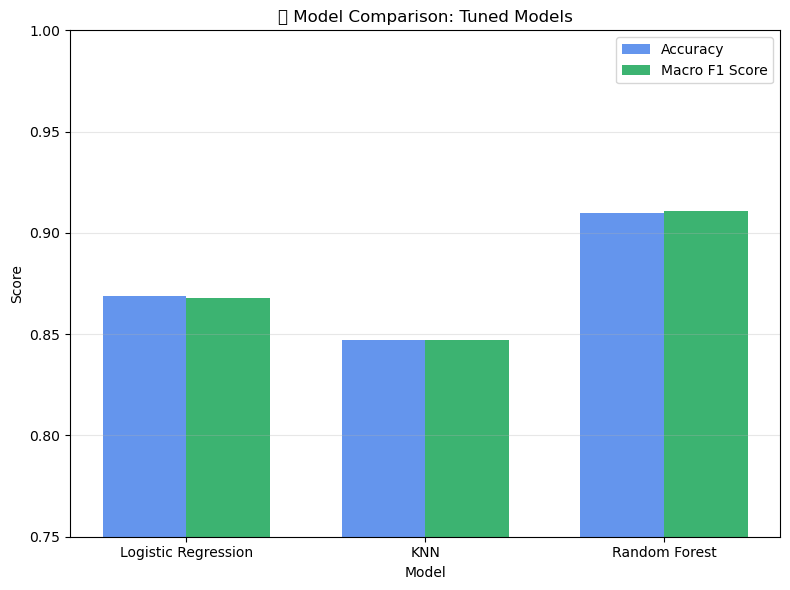

In [94]:
import matplotlib.pyplot as plt

# Updated results from your tuned models
model_names = ['Logistic Regression', 'KNN', 'Random Forest']
accuracy_scores = [0.869, 0.847, 0.910]         # From your final results
f1_scores = [0.868, 0.847, 0.911]               # Macro F1 scores

x = range(len(model_names))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x, accuracy_scores, width=width, label='Accuracy', color='cornflowerblue')
plt.bar([i + width for i in x], f1_scores, width=width, label='Macro F1 Score', color='mediumseagreen')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('📊 Model Comparison: Tuned Models')
plt.xticks([i + width/2 for i in x], model_names)
plt.ylim(0.75, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### Model Comparison – After Hyperparameter Tuning

This section presents the results after tuning Logistic Regression, Random Forest, and K-Nearest Neighbors using GridSearchCV with cross-validation.

| Model                | Accuracy | Macro F1 Score |
|---------------------|----------|----------------|
| Logistic Regression | 86.94%   | 0.87           |
| Random Forest       | 91.04%   | 0.91           |
| KNN                 | 84.70%   | 0.85           
#### 📝 Summary of Tuned Models:

- **Random Forest (Tuned)**:
  - **Accuracy:** 91.04%, **F1:** 0.91
  - Outstanding overall performance with balanced precision and recall.
  - Best handling of all three cost tiers with High Tier reaching an F1 of 0.93.
  - Confusion matrix shows minimal overlap between classes.

- **Logistic Regression (Tuned)**:
  - **Accuracy:** 86.94%, **F1:** 0.87
  - Improved performance from baseline, especially in recall for Low and Medium tiers.
  - High Tier prediction remains cautious (high precision, lower recall), which might be ideal for cost-sensitive use cases.

- **KNN (Tuned)**:
  - **Accuracy:** 84.70%, **F1:** 0.85
  - Gains from tuning were modest.
  - Shows good balance but still more confusion in classifying Med and High tiers.

#### 📌 Key Takeaway:
Hyperparameter tuning yielded significant improvements, especially for **Random Forest**, which stands out as the most accurate and reliable model. It would be the best candidate for deployment or further interpretation using SHAP or LIME.



##  Final Model Selection: Tuned Random Forest

After training and evaluating multiple models—including Logistic Regression, K-Nearest Neighbors (KNN), and Random Forest—we selected the **Tuned Random Forest** as the final model for insurance cost tier prediction.

###  Why Random Forest?

- **Best Performance**:  
  Achieved the highest validation accuracy (**91.04%**) and macro F1 score (**0.91**) among all models.

- **Balanced Predictions**:  
  Demonstrated strong performance across all three tiers:
  - High: F1 = 0.93  
  - Medium: F1 = 0.90  
  - Low: F1 = 0.90

- **Robustness**:  
  As an ensemble method, Random Forest is less prone to overfitting and handles mixed data types (numerical and categorical) well.

- **Interpretability**:  
  Although not as transparent as Logistic Regression, Random Forest provides **feature importance**, which is valuable for understanding key drivers of prediction (e.g., `smoker`, `bmi`, `age`).

- **Scalability and Practicality**:  
  Random Forest can be efficiently deployed and retrained on new data, making it suitable for real-world insurance applications.

 Based on performance, interpretability, and reliability, the **Tuned Random Forest model** is selected as the final model for deployment or further use.
